# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & \pi & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Planning horizon length.
H = 3 * N  # Episode length.
U_MAX = torch.tensor([10.0])  # Maximum action.
U_MIN = -U_MAX  # Minimum action.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(Z.shape[0]) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=1, tol=0,
                             on_iteration=on_iteration, u_min=U_MIN, u_max=U_MAX)


iteration 1 iLQRState.REJECTED 24.109009 [-0.2029478   0.07056269  1.7646362   1.6830409 ]
iteration 1 iLQRState.REJECTED 24.109009 [-0.2029478   0.07056269  1.7646362   1.6830409 ]
iteration 1 iLQRState.REJECTED 24.109009 [-0.2029478   0.07056269  1.7646362   1.6830409 ]
iteration 1 iLQRState.REJECTED 24.109009 [-0.2029478   0.07056269  1.7646362   1.6830409 ]
iteration 1 iLQRState.REJECTED 24.109009 [-0.2029478   0.07056269  1.7646362   1.6830409 ]
iteration 1 iLQRState.REJECTED 24.109009 [-0.2029478   0.07056269  1.7646362   1.6830409 ]
iteration 1 iLQRState.ACCEPTED 20.336573 [ 0.1666035  -0.17422894 -1.1710631   8.907133  ]



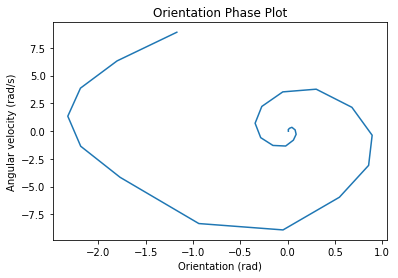

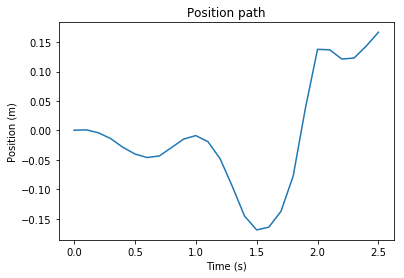

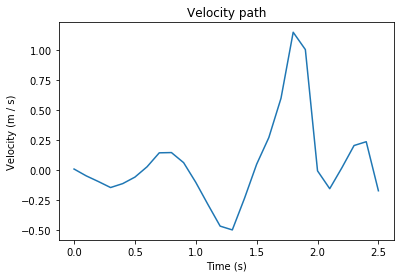

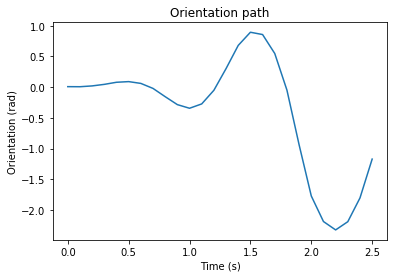

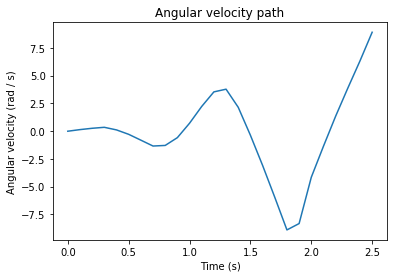

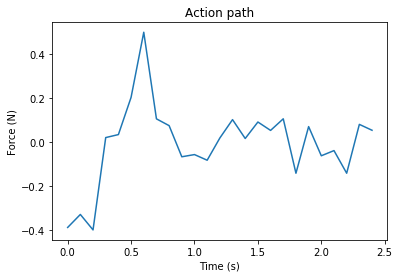

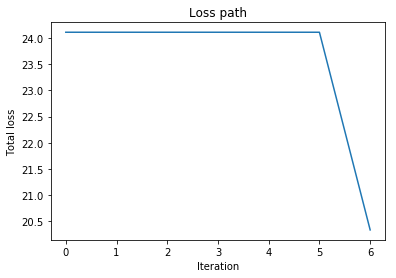

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
env.reset()
Z = torch.empty(H + 1, Z.shape[-1])
U = torch.empty(H, model.action_size)
Z[0] = env.get_state().encode(ENCODING)
for i in range(H):
    U[i] = controller(Z[i], i, ENCODING, mpc=True, u_min=U_MIN, u_max=U_MAX, on_iteration=on_iteration)
    env.apply(U[i])
    Z[i + 1] = env.get_state().encode(ENCODING)

iteration 1 iLQRState.ACCEPTED 19.301332 [ 0.16763869  0.4351131  -2.0187376   6.0812955 ]
iteration 2 iLQRState.ACCEPTED 18.399097 [ 0.2247372   0.49061263 -1.941934    6.5011196 ]
iteration 3 iLQRState.ACCEPTED 16.936525 [ 0.2189233  0.3958189 -2.8618374  1.9177915]
iteration 4 iLQRState.REJECTED 15.930722 [ 0.2585052   0.52794415 -2.6700583   3.1122081 ]
iteration 4 iLQRState.REJECTED 15.930722 [ 0.2585052   0.52794415 -2.6700583   3.1122081 ]
iteration 4 iLQRState.REJECTED 15.930722 [ 0.2585052   0.52794415 -2.6700583   3.1122081 ]
iteration 4 iLQRState.REJECTED 15.930722 [ 0.2585052   0.52794415 -2.6700583   3.1122081 ]
iteration 4 iLQRState.REJECTED 15.930722 [ 0.2585052   0.52794415 -2.6700583   3.1122081 ]
iteration 4 iLQRState.REJECTED 15.930722 [ 0.2585052   0.52794415 -2.6700583   3.1122081 ]
iteration 4 iLQRState.ACCEPTED 15.915667 [ 0.26499572  0.5662424  -2.599788    3.5247693 ]
iteration 5 iLQRState.REJECTED 14.955589 [ 0.32161996  0.6796698  -2.247311    5.3355184 ]
ite

iteration 74 iLQRState.ACCEPTED 5.7544476e-08 [-4.1190109e-05 -1.0889284e-04  3.1414871e+00 -7.1951695e-04]
iteration 75 iLQRState.ACCEPTED 4.618651e-08 [-3.9761355e-05 -1.0331803e-04  3.1414890e+00 -7.0585951e-04]


In [16]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


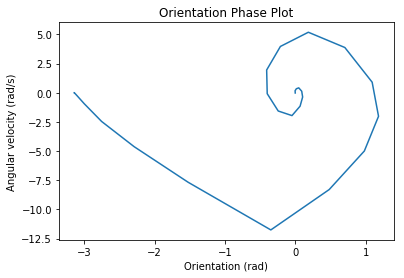

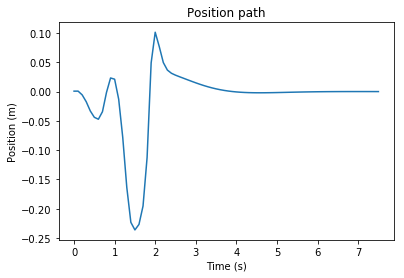

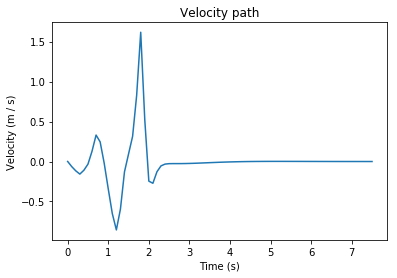

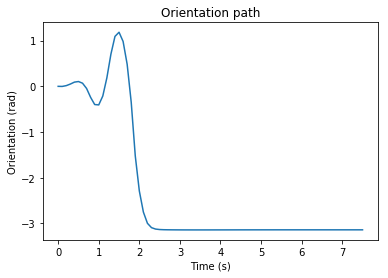

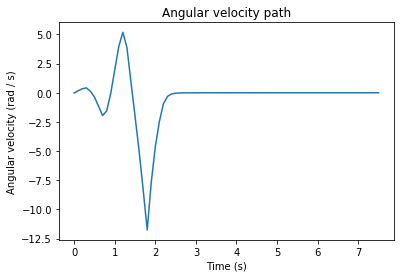

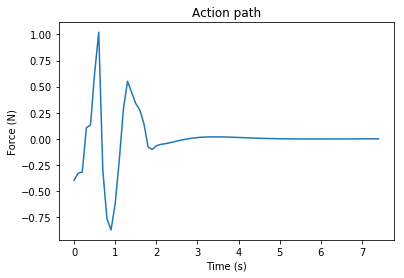

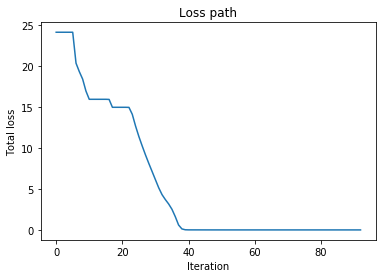

In [17]:
plot(Z, U)

In [18]:
for i in range(10):
    env.apply(torch.zeros(model.action_size))

In [19]:
env.close()